# Imports

In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
path_to_run_results = "/home/knut/Documents/project/UnseededRun_results"
path_to_plots = "/home/knut/Documents/project/UnseededRun_results/plots"
runs = []

for i in range(1, 6):
    p1 = os.path.join(path_to_run_results, "run" + str(i))
    p2 = os.path.join(path_to_run_results, "rs" + str(i))
    runs.append((p1, p2))

In [3]:
def get_convergence_data(df):
    i = 0
    plot_data = []
    for index, row in df.iterrows():
        if i > 14:
            break
        i += 1
        data = {}
        for j in range(100):
            if j == 0:
                data[j] = row[j]
            else:
                if row[j] < data[j - 1]:
                    data[j] = row[j]
                else:
                    data[j] = data[j - 1]
        plot_data.append(data)
    return plot_data    

In [4]:
def make_mean_plot(bo_mean, bo_std, rs_mean, rs_std, name, h_str):

    fig, axis = plt.subplots(figsize=(6, 8))
    steps = 100

    x = np.linspace(0, 99, 100)

    axis.plot(bo_mean, color='C0', label='BO')
    """
    axis.fill(np.concatenate([x, x[::-1]]),
              np.concatenate([bo_mean - 1.9600 * bo_std, (bo_mean + 1.9600 * bo_std)[::-1]]),
              alpha=.2, fc='C0', ec='None', label='95% confidence interval')
    """
    axis.plot(rs_mean, color='C1', label='RS')
    """
    axis.fill(np.concatenate([x, x[::-1]]),
              np.concatenate([rs_mean - 1.9600 * rs_std, (rs_mean + 1.9600 * rs_std)[::-1]]),
              alpha=.2, fc='C1', ec='None', label='95% confidence interval')
    """
    
    axis.set_ylabel('MSE', fontdict={'size':16})
    axis.set_xlabel('Trials', fontdict={'size':16})
    
    axis.legend(loc="upper right")
    plt.title(f'Optimizing {str(i+1)} {h_str}', fontsize=18)
    
    #axis.set_ylim((bo_mean[99]-0.5, rs_mean[99]+2))
    plt.yscale("log")
    plt.grid()
    plt.savefig(name, bbox_inches='tight')

In [5]:
def make_all_plot(bo_df, bo_mean, rs_df, rs_mean, name, h_str):    
    fig, axis = plt.subplots(figsize=(6, 8))
    axis.set_ylabel('MSE', fontdict={'size':16})
    axis.set_xlabel('Trials', fontdict={'size':16})
    #axis.set_ylim((bo_mean[99]-0.5, rs_mean[99]+2))
    plt.title(f'Optimizing {str(i+1)} {h_str}', fontsize=18)
    plt.yscale("log")
    bo_df.head(15).transpose().plot(ax=axis, color='C0', alpha=0.2)
    rs_df.head(15).transpose().plot(ax=axis, color='C1', alpha=0.2)
    axis.get_legend().remove()
    axis.plot(bo_mean, color='C0', label='BO')
    axis.plot(rs_mean, color='C1', label='RS')
    
    plt.grid()
    plt.savefig(name, bbox_inches='tight')
    

In [6]:
def make_violin_plot(df, name, h_str):
    ax = sns.catplot(x="search", y="mean", kind="violin", col="space", data=df, inner="box")
    plt.ylabel('MSE', fontsize=16)
    plt.xlabel('Optimization Algorithm', fontsize=16)
    plt.title(f'Optimizing {str(i+1)} {h_str}', fontsize=18)
    plt.grid()
    plt.savefig(name, bbox_inches='tight')

BO: /home/knut/Documents/project/UnseededRun_results/run1 ||| RS: /home/knut/Documents/project/UnseededRun_results/rs1
BO: /home/knut/Documents/project/UnseededRun_results/run2 ||| RS: /home/knut/Documents/project/UnseededRun_results/rs2
BO: /home/knut/Documents/project/UnseededRun_results/run3 ||| RS: /home/knut/Documents/project/UnseededRun_results/rs3
BO: /home/knut/Documents/project/UnseededRun_results/run4 ||| RS: /home/knut/Documents/project/UnseededRun_results/rs4
BO: /home/knut/Documents/project/UnseededRun_results/run5 ||| RS: /home/knut/Documents/project/UnseededRun_results/rs5


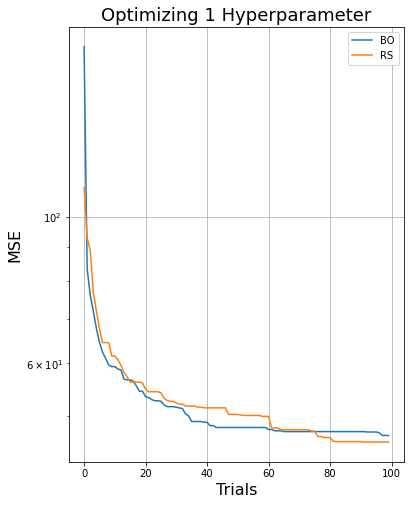

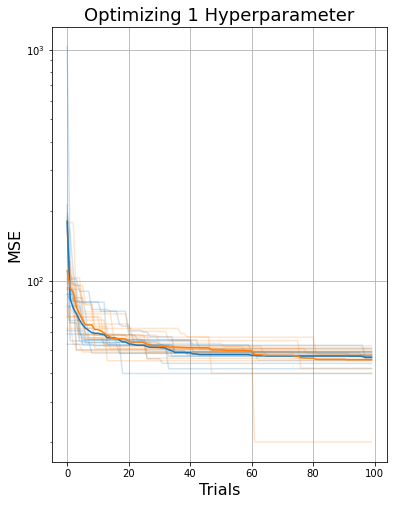

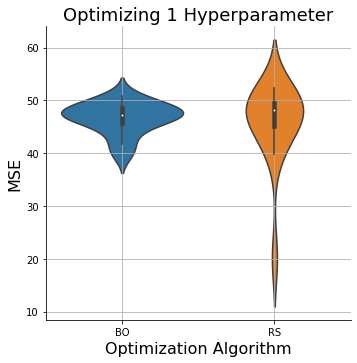

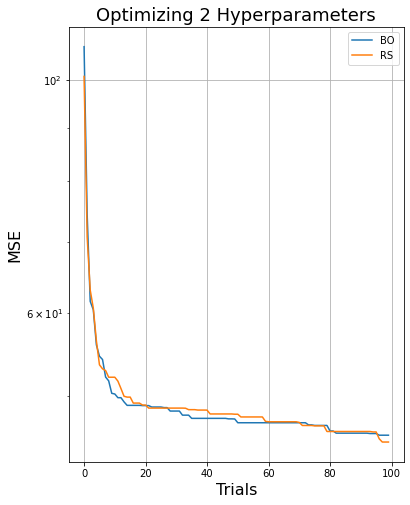

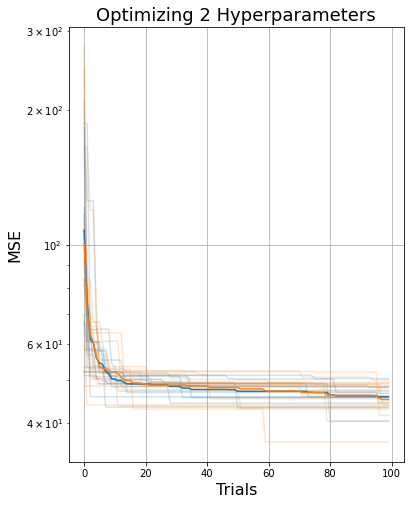

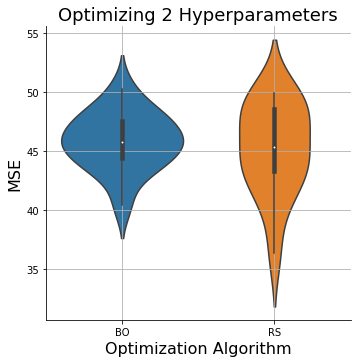

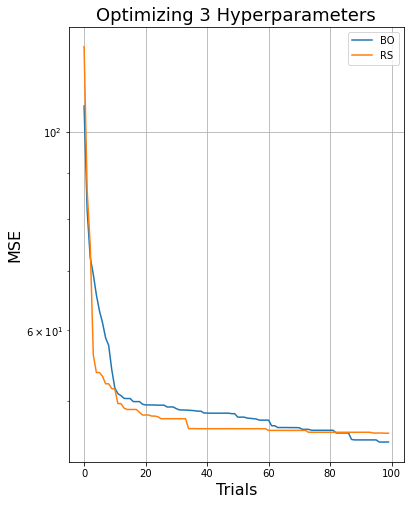

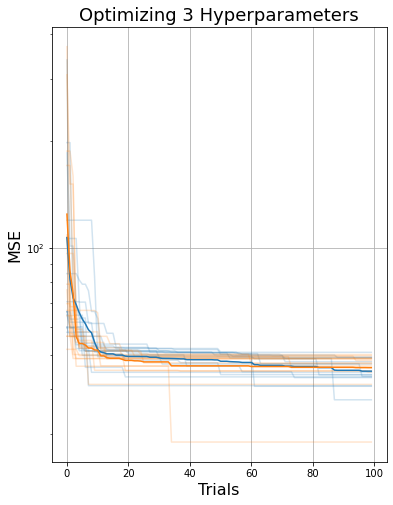

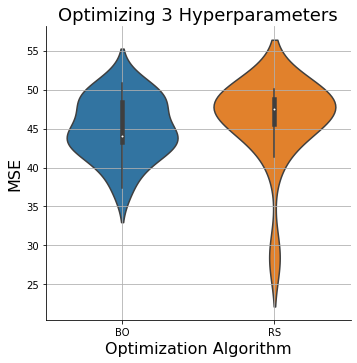

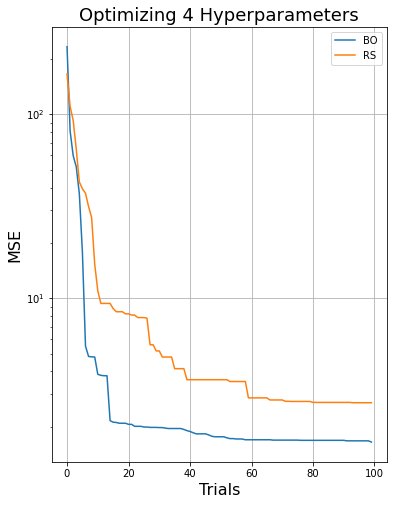

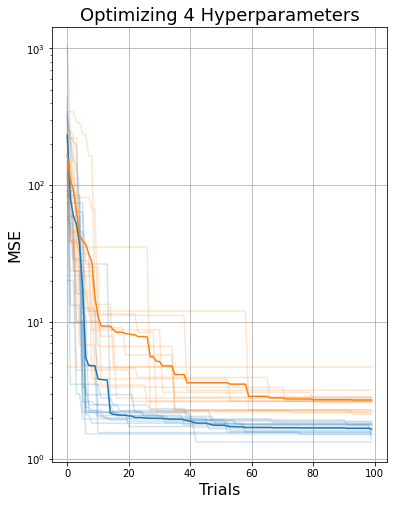

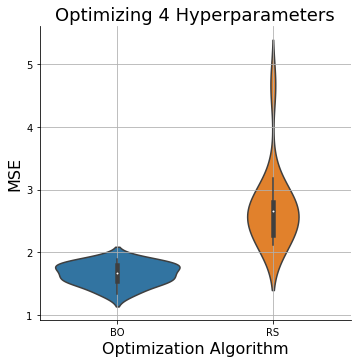

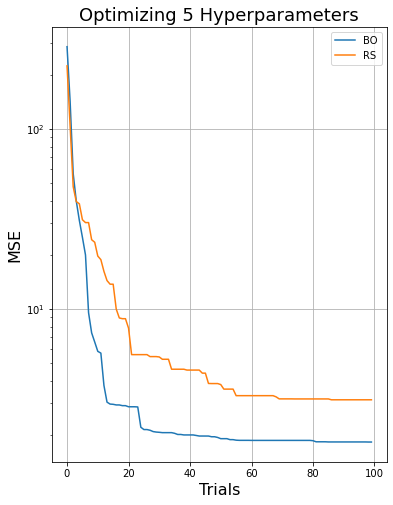

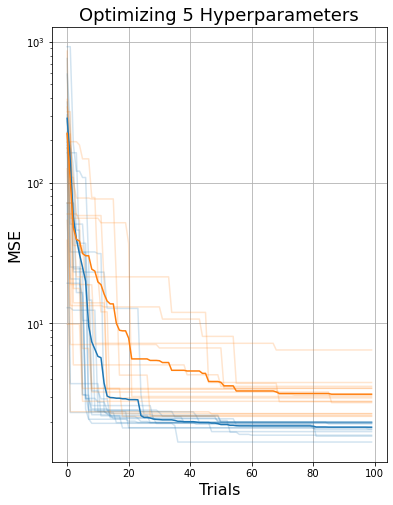

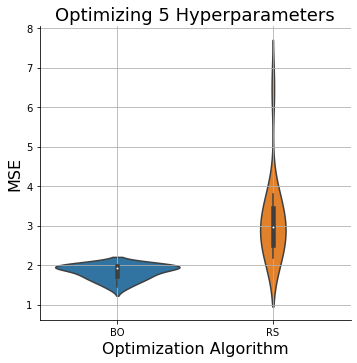

In [7]:
for i, (bo_path, rs_path) in enumerate(runs):
    final = []
    search = []
    space = []
    
    print(f'BO: {bo_path} ||| RS: {rs_path}')
    bo_csv = os.path.join(bo_path, "results.csv")
    rs_csv = os.path.join(rs_path, "results.csv")
    bo_config_csv = os.path.join(bo_path, "config.csv")
    rs_config_csv = os.path.join(rs_path, "config.csv")

    bo_df = pd.read_csv(bo_csv, index_col=0)
    rs_df = pd.read_csv(rs_csv, index_col=0)
    bo_config_df = pd.read_csv(bo_config_csv, index_col=0)
    rs_config_df = pd.read_csv(rs_config_csv, index_col=0)

    bo_df = pd.DataFrame(get_convergence_data(bo_df))
    bo_max = bo_df.to_numpy().max()
    bo_min = bo_df.to_numpy().min()
    bo_mean = bo_df.mean(axis=0)
    bo_var = bo_df.var(axis=0)
    bo_std = bo_df.std(axis=0)
    bo_df.loc["mean"] = bo_mean
    bo_df.loc["var"] = bo_var
    bo_df.loc["std"] = bo_std
    
    final = final + (bo_df.head(15).loc[:, 99].to_numpy().tolist())
    search = search + ["BO"]*15
    space = space + [i+1]*15
    

    rs_df = pd.DataFrame(get_convergence_data(rs_df))
    rs_max = rs_df.to_numpy().max()
    rs_min = rs_df.to_numpy().min()
    rs_mean = rs_df.mean(axis=0)
    rs_var = rs_df.var(axis=0)
    rs_std = rs_df.std(axis=0)
    rs_df.loc["mean"] = rs_mean
    rs_df.loc["var"] = rs_var
    rs_df.loc["std"] = rs_std
    
    final = final + (rs_df.head(15).loc[:, 99].to_numpy().tolist())
    search = search + ["RS"]*15
    space = space + [i+1]*15
    
    h_str = "Hyperparameters" if i > 0 else "Hyperparameter"
    
    name = os.path.join(path_to_plots, "run"+str(i+1)+".pdf")
    make_mean_plot(bo_mean, bo_std, rs_mean, rs_std, name, h_str)
    
    name = os.path.join(path_to_plots, "run"+str(i+1)+"_all.pdf")
    make_all_plot(bo_df, bo_mean, rs_df, rs_mean, name, h_str)
    
    d = {"mean": final, "search": search, "space": space}
    df = pd.DataFrame(data=d)
    name = os.path.join(path_to_plots, "run"+str(i+1)+"_violin.pdf")
    make_violin_plot(df, name, h_str)
